# Project: Train a Quadcopter How to Fly

I leave only the cells where I have to put something. I remove all the parts that are not relevant to clear the notebook.

## Notes

In the introduction there is the following statement:
- `physics_sim.py`: This file contains the simulator for the quadcopter.  **DO NOT MODIFY THIS FILE**.

About this point, I had to modify some lines in this file. There is some discussion about it in these 2 forum threads that I started:
https://discussions.udacity.com/t/some-doubts-about-the-version-2-of-the-project/637475
https://discussions.udacity.com/t/the-sudden-attack-of-the-nans-project-v2/642588

As you can see in my code, I modified the reset function, since before it was not using the copy.copy() function to give the initial values on each episode, and therefore those initial values where the same variables in memory as the ones changing and the reset had no effect (speed and others were maintained between episodes).

I removed the angle wrapping:
#angles = (angles + 2 * np.pi) % (2 * np.pi)
As in a physical simulation, I cannot understand the point of the angle jumping a full turn all the time. 

## The Task

I did an extensive research of hyperparameters, and from forums and other students, it was clear that a search far from the samples values was necessary.

I have done such exploration with that goal task of having the quadcopter hovering. For this task, the start point and the final goal are the same, and the goal is to hover in that position.

### The implementation
The actor, the critic and the agent for this attempt if based on the code provided by the project lesson in the classroom. There is a file for each class: actor, critic, agent and task.

To run the code you can run from console: *python main.py*. After the explanations I will leave a cell from which it can be run.

After attempting to use a state space with all the pose values and one action per rotor, and not succeeding to train the copter, I sent the project for revision and the suggestion was to reduce this spaces. I finall used 3 states: position in z, velocity in z, and goal position in z. 

This way it finally worked, and I believe with a great amount of time it would work as well including more states and action parameters.

### The rewards

I implemented the rewards in a defaultdict, as this allows to directly add different rewards that I think useful in an independent manner and they will be added to the rewards to be optimized by the agent, plus they will be plot independently automatically (in the results this can be appreciated). It is very useful to see the effect of each reward independently. 

For example, the 2 basic rewards are related to distance to the goal, and speed:
    
    def distance_reward(self):
        current_position = self.sim.pose[:3]
        target_position = self.target_pos
        # Since the norm is positive, tanh will give a value between 0 and 1.
        reward = 4.0 * (1.0 - np.tanh(np.linalg.norm(current_position - target_position) * 0.10))

        return reward

    def speed_reward(self):
        # Penalizing speed will favor more stable motion.
        reward = 1.0 - np.tanh(np.abs(self.sim.v).sum() * 1.0)

        # But only when we are close to the target position. To avoid encouraging the quadcopter to stop in other random places.
        current_position = self.sim.pose[:3]
        target_position = self.target_pos
        distance = np.linalg.norm(current_position - target_position)
        # The multiplier is 1 when the distance is 0, and decrease to 0 when we move from there.
        multiplier = np.exp(-distance** 2) 
        
        return reward * multiplier
        
    def get_reward(self, rotor_speeds):
        """Uses current pose of sim to return reward."""
        rewards = defaultdict(float)

        if self.sim.done:
            if self.sim.reached_limits:
                rewards['surviving'] = -1.0
            else:
                rewards['surviving'] = 1.0
        else:
            rewards['surviving'] = 0.1

        # Any reward added here will be added automatically and plotted at the end.
        rewards['distance'] = self.distance_reward()
        rewards['speed'] = self.speed_reward()

        reward = sum([x for x in rewards.values()])
        return reward, rewards

All the rewards are wrapped with tanh or sigmoid functions, in order to have bounds from -1 to 1, or from 0 to 1, and easily give importance to each specific reward compared to the others.


## Plot the results

I have done the following grid search of hyperparameters:

    test_values = [1.0e-3, 1.0e-4, 1.0e-5,1.0e-6, 1.0e-7] # actor_learning_rate
    test_values = [1.0e-2, 1.0e-3, 1.0e-4,1.0e-5] # critic_learning_rate
    test_values = [0.9, 0.99] # gamma
    test_values = [0.2, 0.02, 0.002, 0.0002] # exploration_sigma
    test_values = [0.1, 0.01, 0.001, 0.0001] # tau
    test_values = [0.9, 0.99] # gamma
    
Plus I have compared different network sizes and structures for the actor and critic:

- Mixing state and action nets with concatenation or adding in the critic network.
- Different sizes and numbers of layers.
- With/without batch normalization.
- With/without dropout.
- Different weight initialization (normal distribution instead of default Gorot).

The best combination found has been this:

With a learning curve as follows:

![](figures_to_keep\tau_learning.png)


Using TensorFlow backend.




Start training...

Running test episode ...
state [ 10.   0.  10.]
state.shape (3,)
Finished test episode!

Episode:  20 (stuck:    0), score:     2.1, reward:   378.13, noise(sigma:  0.020, theta:  0.150, state,   -0.0)(action: 487.3). Time:   6.9 s.  Ep:  20. Step:   1, reward:   5.0, noise(sigma: 0.0200, theta: 0.150, state,   0.1)(action: 481.6), (state:  10.0,   0.0, 10.0), (next_state:  10.0,   0.1, 10.0) pose (   0.0,   0.0,  10.0,   0.0,   0.0,   0.0) done: False
  Ep:  20. Step:   2, reward:   4.9, noise(sigma: 0.0200, theta: 0.150, state,   0.0)(action: 481.6), (state:  10.0,   0.1, 10.0), (next_state:  10.0,   0.2, 10.0) pose (   0.0,   0.0,  10.0,   0.0,   0.0,   0.0) done: False
  Ep:  20. Step:   3, reward:   4.9, noise(sigma: 0.0200, theta: 0.150, state,   0.0)(action: 481.6), (state:  10.0,   0.2, 10.0), (next_state:  10.0,   0.2, 10.0) pose (   0.0,   0.0,  10.0,   0.0,   0.0,   0.0) done: False
  Ep:  20. Step:   4, reward:   4.8, noise(sigma: 0.0200, theta: 0.150, 

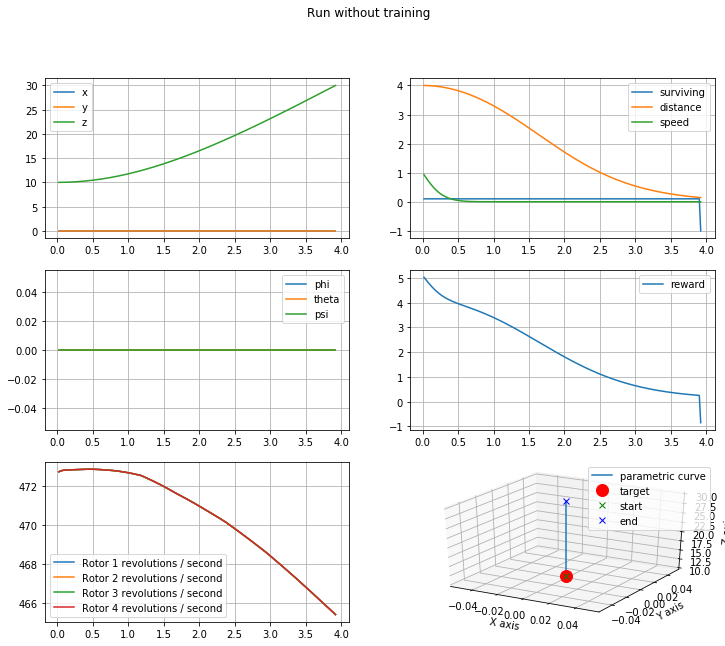

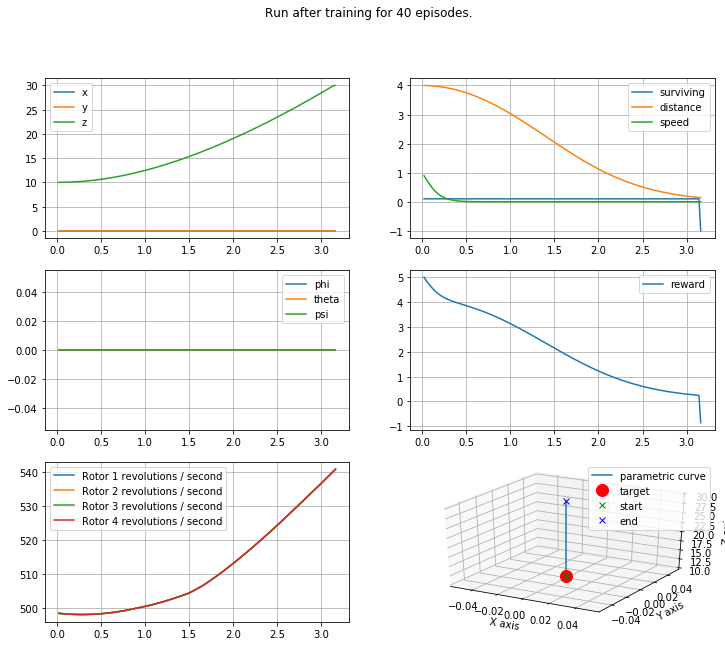

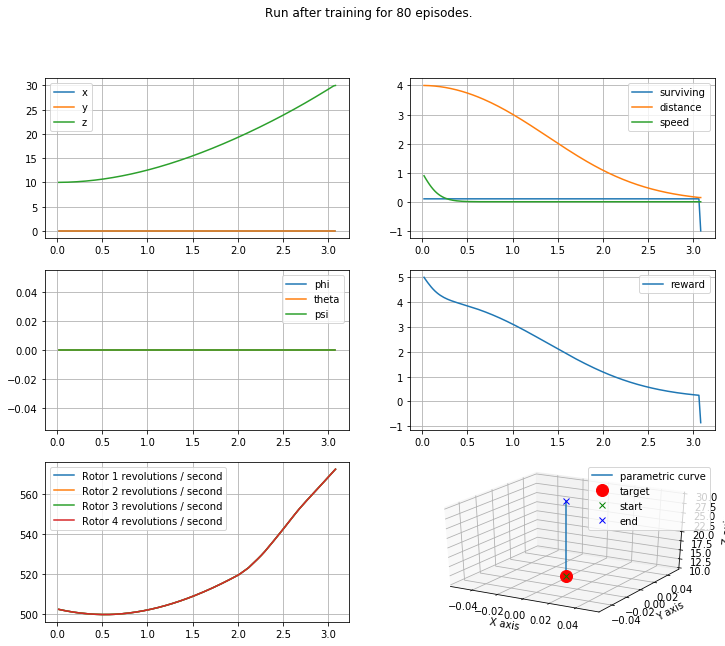

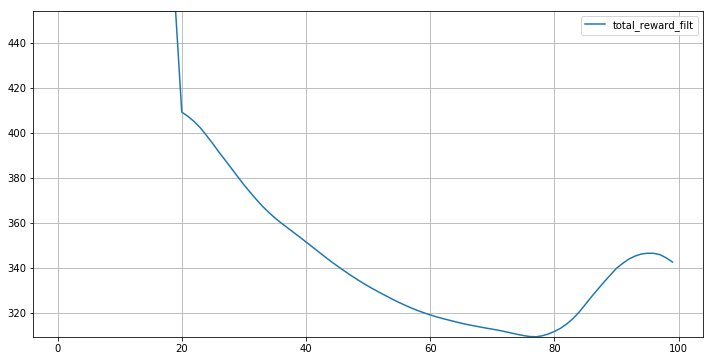

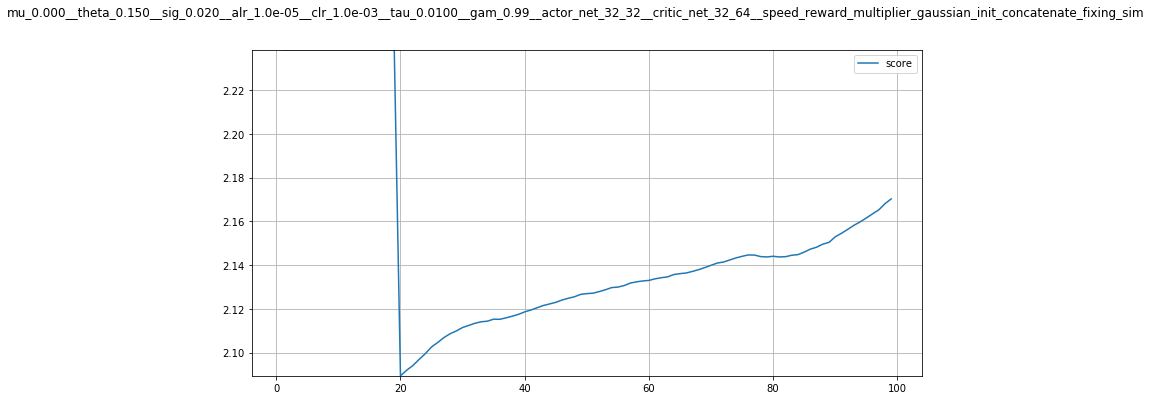

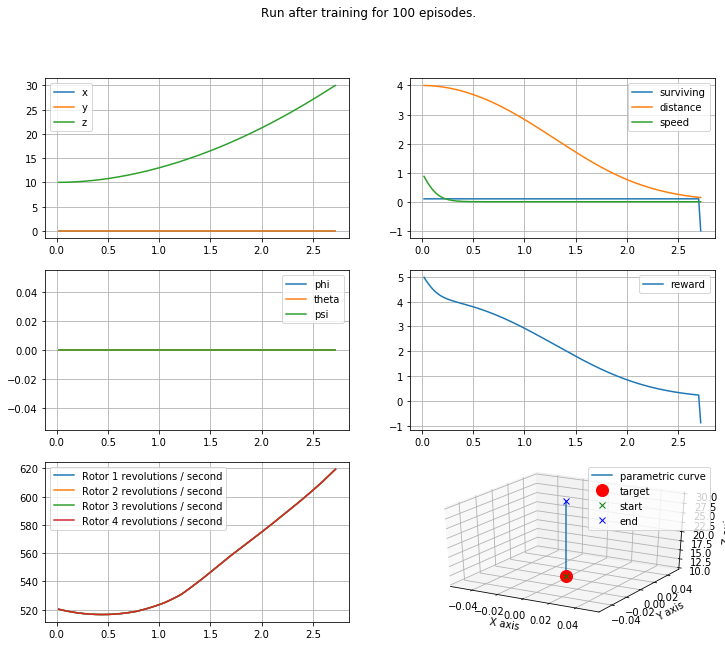

In [2]:
# This is just an example of the code running. The actual tuning was done in the several batch_test_XXX.py files.

import main

## Reflections

**Question 1**: Describe the task that you specified in `task.py`.  How did you design the reward function?

**Answer**:
The task studied is hovering, and therefore the start is (0, 0, 10), and also the target point.

In the figure below it is shown how the agent perform the task after training 400 cycles. It stays in position (3D image bottom right). 

![](figures_to_keep\best_hovering.png)

**Question 2**: Discuss your agent briefly, using the following questions as a guide:

- What learning algorithm(s) did you try? What worked best for you?
- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)?
- What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.

**Answer**:

I tried the Deep Deterministic Policy Gradients, with 2 different implementations adapted to the task at hand. 

For hyperparameters, I tried many different ones, as shown above in the grid of parameters.

These come from different places: the DDPG paper and in the implementations found on the internet.

For the neural networks I followed 3 starting points:
- The code given to start.
- A project with good reputation: https://github.com/yanpanlau/DDPG-Keras-Torcs
- The DDPG paper.

For actor, I use a 2 layer neural network, with parametrizable size (final values 32, 32 cells). 

For the critic I use 2 branches starting in states and actions respectively, with 1 layer for the actions and 2 for the states. The output of those branches are merged by adding (also checked concatenation), and another layer is used. Finally a single unit layer with the output. The sizes are 32, 64, 32 units for the layers (except for the actions with skips the first value since has one less layer.


**Question 3**: Using the episode rewards plot, discuss how the agent learned over time.

- Was it an easy task to learn or hard?
- Was there a gradual learning curve, or an aha moment?
- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)

**Answer**:

The task was hard to learn, mainly due to the lack of previous experience training agents like DDPG. The useful hyperparameters were far from the starting ones, also the reward funtion.

A problem has been that once the networks became complex (dropout, batch normalization, etc), it was slow to run episodes, and with so many hyperparameters to tune, it has been difficult to train many. Actually having more time would have been much better to keep tuning the network.

There has been aha moments in several hyperparameters tuning... specifically the actor learning rate, it had to be much lower that the start value, and also for example the noise, which I thought should be big to explore, but actually this works when it is small.

**Question 4**: Briefly summarize your experience working on this project. You can use the following prompts for ideas.

- What was the hardest part of the project? (e.g. getting started, plotting, specifying the task, etc.)
- Did you find anything interesting in how the quadcopter or your agent behaved?

**Answer**:

It has been very hard to find a track to follow. The lessons were not enough, specially regarding trying something similar before dealing with the project.

I found some clues on where to go from other github repos applying DDPG and the forum/slack with other students. But clearly there is not a big support for this project.

I find the project very interesing as I am a big fan of deep reinforcement learning in general. I am very interested in keeping learning this technique and will apply to other projects